# 비상장 중소기업의 상장 후 주가 예측 프로젝트

이 프로젝트는 비상장 중소기업의 상장 후 주가 예측 프로젝트이다. 과거 중소기업의 데이터와 상장 후 주가의 산술평균 데이터를 이용할 것이다. 중소기업의 데이터는 기업 내 재무재표와 거시정보를 이용한다.

기본설정

In [1]:
import numpy as np 
import os  
import matplotlib ##그림용
import matplotlib.pyplot as plt ##그림용
import sklearn ##사이킷런
import pandas as pd

np.random.seed(42) ##랜덤시드 

matplotlib.rc('font', family='NanumBarunGothic') ##matplotlib 한글을 위해
plt.rcParams['axes.unicode_minus'] = False ##한글을 위해

In [2]:
DATA = pd.read_csv('datasets//DB//DB_data.csv', engine='python')

# 기업규모명

우리가 예측하고 싶은 대상은 중소기업이므로 중소기업만 관찰한다.

In [3]:
data = DATA[DATA["기업규모명"] == '중소기업']
data["산술평균"].describe()

count     19405.000000
mean       8759.684411
std       20053.079221
min          94.000000
25%        2299.000000
50%        4356.000000
75%        8733.000000
max      604000.000000
Name: 산술평균, dtype: float64

우리의 타겟값인 산술평균이 없는 경우 데이터에서 제외한다.

In [5]:
data = data[-(data["산술평균"].isnull())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19405 entries, 0 to 47773
Data columns (total 41 columns):
회사명                  19405 non-null object
회계년도                 19405 non-null object
산업명                  19405 non-null object
소속코드                 19405 non-null float64
설립일                  19405 non-null object
종업원                  19405 non-null float64
당좌자산(*)              19134 non-null float64
재고자산(*)              19134 non-null float64
비유동자산(*)             19134 non-null float64
유동부채(*)              19134 non-null float64
비유동부채(*)             19134 non-null float64
자본금(*)               19134 non-null float64
자본잉여금(*)             19134 non-null float64
자본조정(*)              19134 non-null float64
기타포괄손익누계액(*)         19134 non-null float64
이익잉여금(*)             19134 non-null float64
매출액(영업수익)(*)         19134 non-null float64
매출원가(*)              19134 non-null float64
매출총이익(손실)            19134 non-null float64
판매비와관리비(영업비용)(*)     19134 non-null float64
영업이익(손실)       

In [6]:
data.shape

(19405, 41)

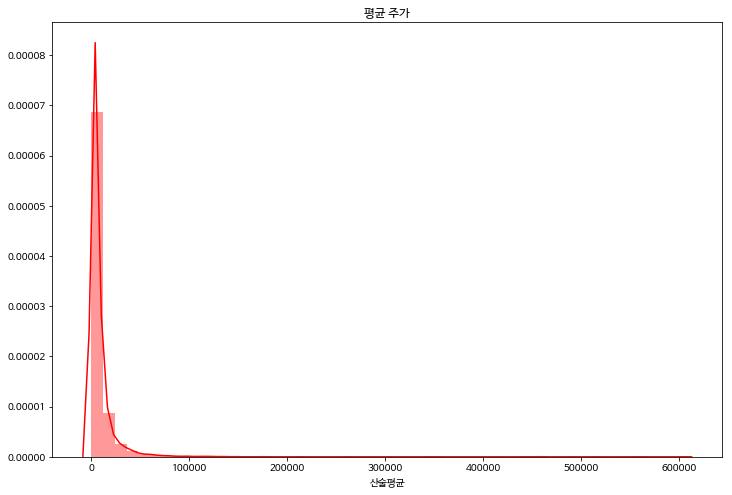

In [8]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.distplot(data["산술평균"], color='red')
plt.title('평균 주가')
plt.show()

주어진 데이터의 오른쪽 꼬리가 길게 뻗어있다.

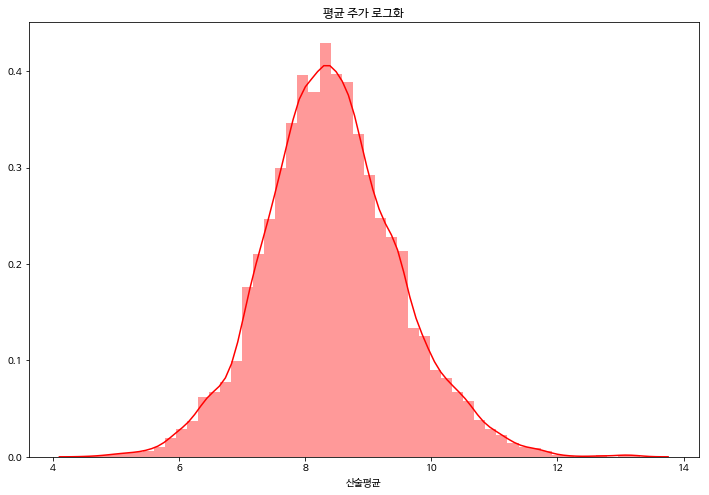

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data["산술평균"]+ 0.1), color='red')
plt.title('평균 주가 로그화')
plt.show()

주어진 타겟값을 log화하니, 정규분포의 모습과 상당히 비슷해졌다. 나중에 타겟값을 나중에 log화 해야한다.

# 데이터 구조 훑어보기

우리의 데이터를 간략하게 살펴보자.

In [10]:
data.head()

,회사명,회계년도,산업명,소속코드,설립일,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),...,현금의 증가(감소)(*),기업규모명,산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지,발행주식수
0,(주)CMG제약,2011-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,9917659.0,3104211.0,15477735.0,4969819.0,...,-265171.0,중소기업,873.0,1.0,34.1,81.3,4.2,1939.30,-4253.0,108887244.0
1,(주)CMG제약,2011-06-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11341653.0,3071427.0,14731279.0,5976935.0,...,-1160724.0,중소기업,577.0,0.6,34.1,80.6,3.4,2142.47,-2470.6,108887244.0
2,(주)CMG제약,2011-09-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11407699.0,3352328.0,14717723.0,6389723.0,...,-1961689.0,중소기업,993.0,0.7,34.8,80.9,3.1,1880.11,11405.6,108887244.0
3,(주)CMG제약,2011-12-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,12521782.0,2743103.0,12283654.0,7620349.0,...,-1294857.0,중소기업,775.0,0.6,35.2,79.3,2.9,1847.51,11956.2,108887244.0
4,(주)CMG제약,2012-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,13370740.0,3654331.0,12100895.0,8146944.0,...,435947.0,중소기업,892.0,0.5,34.3,79.7,3.8,2045.08,-1292.0,108887244.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19405 entries, 0 to 47773
Data columns (total 41 columns):
회사명                  19405 non-null object
회계년도                 19405 non-null object
산업명                  19405 non-null object
소속코드                 19405 non-null float64
설립일                  19405 non-null object
종업원                  19405 non-null float64
당좌자산(*)              19134 non-null float64
재고자산(*)              19134 non-null float64
비유동자산(*)             19134 non-null float64
유동부채(*)              19134 non-null float64
비유동부채(*)             19134 non-null float64
자본금(*)               19134 non-null float64
자본잉여금(*)             19134 non-null float64
자본조정(*)              19134 non-null float64
기타포괄손익누계액(*)         19134 non-null float64
이익잉여금(*)             19134 non-null float64
매출액(영업수익)(*)         19134 non-null float64
매출원가(*)              19134 non-null float64
매출총이익(손실)            19134 non-null float64
판매비와관리비(영업비용)(*)     19134 non-null float64
영업이익(손실)       

1. 데이터에는 결측치가 몇 개 보인다.
2. 데이터 타입이 object인 데이터는, 회사명, 회계년도, 산업명, 설립일이 있다.
    - 회사명의 경우 각 데이터의 identity column이므로 나중에 삭제한다.
    - 회계년도의 경우 나중에 분기(03, 06, 09, 12)만 얻어서 명목형 변수로 변환한다.
    - 설립일의 경우년도만 얻어서 수치형 자료로 사용하겠다.
3. 소속코드의 경우 산술 평균과 연관있는 데이터이므로 나중에 삭제해야한다.

# 파일 정제

결측치가 몇 개 보인다. 산술평균의 경우 우리의 타겟값이므로 산술평균에 결측치가 있는 경우 객체를 버린다.

In [12]:
data = data[-(data["산술평균"].isnull())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19405 entries, 0 to 47773
Data columns (total 41 columns):
회사명                  19405 non-null object
회계년도                 19405 non-null object
산업명                  19405 non-null object
소속코드                 19405 non-null float64
설립일                  19405 non-null object
종업원                  19405 non-null float64
당좌자산(*)              19134 non-null float64
재고자산(*)              19134 non-null float64
비유동자산(*)             19134 non-null float64
유동부채(*)              19134 non-null float64
비유동부채(*)             19134 non-null float64
자본금(*)               19134 non-null float64
자본잉여금(*)             19134 non-null float64
자본조정(*)              19134 non-null float64
기타포괄손익누계액(*)         19134 non-null float64
이익잉여금(*)             19134 non-null float64
매출액(영업수익)(*)         19134 non-null float64
매출원가(*)              19134 non-null float64
매출총이익(손실)            19134 non-null float64
판매비와관리비(영업비용)(*)     19134 non-null float64
영업이익(손실)       

데이터의 특성중 당좌좌산(\*)부터 현금의 증가(감소)(\*)의 경우 결측치의 개수가 일정한 것으로보아, 이 중 한 특성에서 결측치가 발생한 경우, 다른 특성에도 결측치가 발생한 것으로 추론할 수 있다.

In [13]:
data = data[-data["당좌자산(*)"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19134 entries, 0 to 47773
Data columns (total 41 columns):
회사명                  19134 non-null object
회계년도                 19134 non-null object
산업명                  19134 non-null object
소속코드                 19134 non-null float64
설립일                  19134 non-null object
종업원                  19134 non-null float64
당좌자산(*)              19134 non-null float64
재고자산(*)              19134 non-null float64
비유동자산(*)             19134 non-null float64
유동부채(*)              19134 non-null float64
비유동부채(*)             19134 non-null float64
자본금(*)               19134 non-null float64
자본잉여금(*)             19134 non-null float64
자본조정(*)              19134 non-null float64
기타포괄손익누계액(*)         19134 non-null float64
이익잉여금(*)             19134 non-null float64
매출액(영업수익)(*)         19134 non-null float64
매출원가(*)              19134 non-null float64
매출총이익(손실)            19134 non-null float64
판매비와관리비(영업비용)(*)     19134 non-null float64
영업이익(손실)       

이 중 발행주식수에 결측치가 있는 샘플이 있는데 샘플의 개수가 적어서 객체를 버리는 것이 좋을 것 같다.

In [14]:
data = data[-data["발행주식수"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19107 entries, 0 to 47773
Data columns (total 41 columns):
회사명                  19107 non-null object
회계년도                 19107 non-null object
산업명                  19107 non-null object
소속코드                 19107 non-null float64
설립일                  19107 non-null object
종업원                  19107 non-null float64
당좌자산(*)              19107 non-null float64
재고자산(*)              19107 non-null float64
비유동자산(*)             19107 non-null float64
유동부채(*)              19107 non-null float64
비유동부채(*)             19107 non-null float64
자본금(*)               19107 non-null float64
자본잉여금(*)             19107 non-null float64
자본조정(*)              19107 non-null float64
기타포괄손익누계액(*)         19107 non-null float64
이익잉여금(*)             19107 non-null float64
매출액(영업수익)(*)         19107 non-null float64
매출원가(*)              19107 non-null float64
매출총이익(손실)            19107 non-null float64
판매비와관리비(영업비용)(*)     19107 non-null float64
영업이익(손실)       

이제 우리의 데이터에 결측치가 있는 샘플이 없어졌다.

# 데이터 구조

## 명목형 변수

### 산업명

각 산업명의 경우에 얼마나 샘플이 속해있는지 살펴보자.

In [15]:
data["산업명"].value_counts()

  전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업    3947
  기타 기계 및 장비 제조업                  2086
  출판업                             1447
  의료용 물질 및 의약품 제조업                1334
  도매 및 상품 중개업                     1207
  화학물질 및 화학제품 제조업; 의약품 제외          983
  의료, 정밀, 광학기기 및 시계 제조업            837
  자동차 및 트레일러 제조업                   708
  전기장비 제조업                         664
  금속가공제품 제조업; 기계 및 가구 제외           589
  고무 및 플라스틱제품 제조업                  521
  컴퓨터 프로그래밍, 시스템 통합 및 관리업          418
  1차 금속 제조업                        370
  영상ㆍ오디오 기록물 제작 및 배급업              288
  연구개발업                            271
  정보서비스업                           260
  식료품 제조업                          259
  기타 운송장비 제조업                      238
  비금속 광물제품 제조업                     211
  종합 건설업                           200
  의복, 의복 액세서리 및 모피제품 제조업           198
  펄프, 종이 및 종이제품 제조업                196
  섬유제품 제조업; 의복제외                   175
  기타 전문, 과학 및 기술 서비스업              144
  소매업; 자동차 제외                      143
  전문 서비스업                

이 데이터를 시각화 해보자.

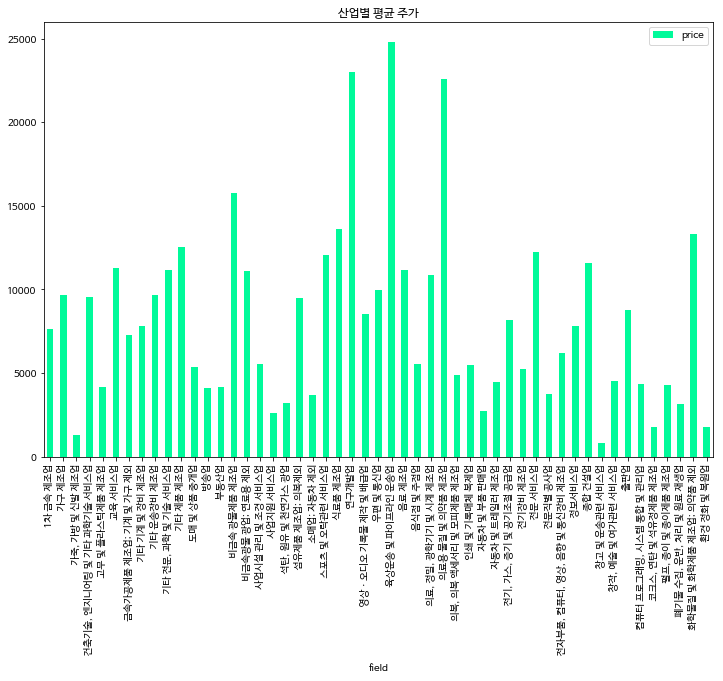

In [16]:
tmp = data[["산업명","산술평균"]].copy()
tmp.columns = ["field", "price"]

tmp.groupby(['field']).mean().plot.bar(figsize=(12,8), color='mediumspringgreen')
plt.title('산업별 평균 주가')
plt.show()

## 수치형 데이터

### 설립일

설립일에 따른 산술 평균

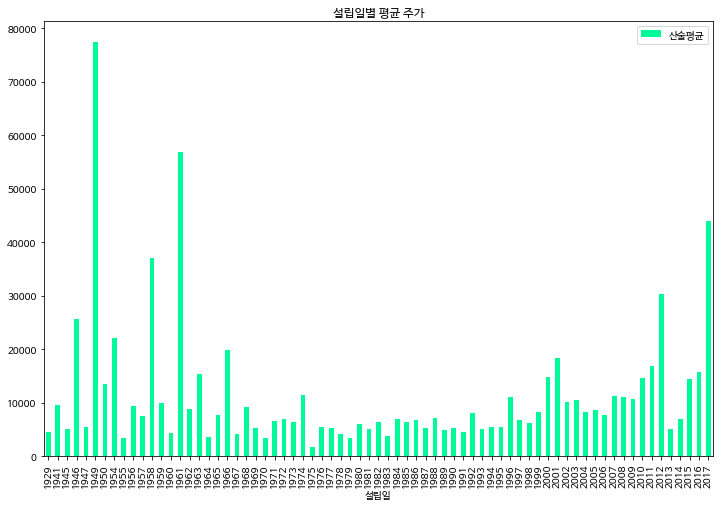

In [17]:
data_est_stock = data[["설립일", '산술평균']].copy()
data_est_stock["설립일"] = data_est_stock["설립일"].str.split('-', n=2, expand=True)[0]

data_est_stock.groupby("설립일").mean().plot.bar(figsize=(12,8), color='mediumspringgreen')
plt.title('설립일별 평균 주가')
plt.show()

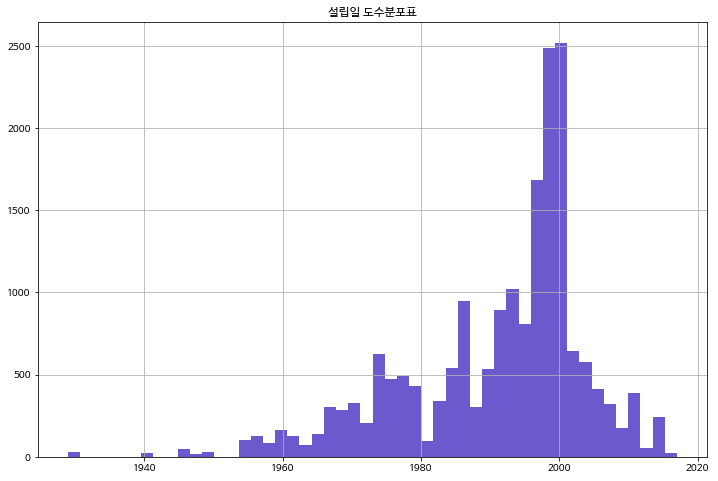

In [18]:
data_est_stock["설립일"].astype('float').hist(bins=50, figsize=(12,8), color='slateblue')
plt.title('설립일 도수분포표')
plt.show()

왼쪽 꼬리에 있는 데이터의 산술평균의 값이 크다.

### 다른 수치형 데이터

In [19]:
data.iloc[:, :20].describe()

,소속코드,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),비유동부채(*),자본금(*),자본잉여금(*),자본조정(*),기타포괄손익누계액(*),이익잉여금(*),매출액(영업수익)(*),매출원가(*),매출총이익(손실),판매비와관리비(영업비용)(*)
count,19107.000000,19107.000000,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04
mean,4.519129,162.578165,3.049682e+07,7.865817e+06,4.003380e+07,2.192998e+07,7.298008e+06,9.187530e+06,2.346354e+07,-2.096587e+06,8.660947e+05,1.774890e+07,3.457534e+07,2.649873e+07,8.076604e+06,6.353134e+06
std,1.374305,152.030716,2.680402e+07,1.013209e+07,3.312486e+07,2.394416e+07,1.195030e+07,9.316377e+06,2.889501e+07,7.129465e+06,3.612816e+06,3.742768e+07,4.087534e+07,3.475461e+07,1.136980e+07,8.255032e+06
min,1.000000,3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.267000e+03,0.000000e+00,-1.596257e+07,-2.760965e+08,-2.112511e+07,-9.113449e+08,0.000000e+00,0.000000e+00,-5.694467e+07,-1.589801e+06
25%,5.000000,70.000000,1.431238e+07,1.344728e+06,1.821529e+07,6.822814e+06,1.096838e+06,4.100000e+06,7.813118e+06,-2.208828e+06,0.000000e+00,-2.712905e+05,1.104204e+07,7.225873e+06,1.956758e+06,2.052374e+06
50%,5.000000,123.000000,2.363233e+07,4.983907e+06,3.249424e+07,1.427676e+07,3.605832e+06,6.057356e+06,1.603420e+07,-5.180450e+05,0.000000e+00,1.621194e+07,2.304322e+07,1.672904e+07,4.788879e+06,4.004710e+06
75%,5.000000,208.000000,3.889526e+07,1.080203e+07,5.285682e+07,2.946723e+07,9.231264e+06,1.043617e+07,2.932932e+07,0.000000e+00,3.571700e+04,3.446814e+07,4.448466e+07,3.399709e+07,1.021150e+07,7.608860e+06
max,6.000000,2044.000000,5.784166e+08,2.200540e+08,3.981119e+08,3.818411e+08,2.075276e+08,1.021334e+08,9.624228e+08,8.052018e+07,1.205210e+08,4.512118e+08,9.696468e+08,9.275899e+08,2.993679e+08,2.588650e+08


In [20]:
data.iloc[:, 20:].describe()

,영업이익(손실),영업외수익(*),영업외비용(*),법인세비용차감전(계속사업)손익,(계속사업손익)법인세비용,계속사업이익(손실),당기순이익(순손실),영업활동으로 인한 현금흐름(*),투자활동으로 인한 현금흐름(*),재무활동으로 인한 현금흐름(*),환율변동으로 인한 차이조정,현금의 증가(감소)(*),산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지,발행주식수
count,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,1.910700e+04,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,1.910700e+04
mean,1.723470e+06,1.528534e+06,1.909749e+06,1.342255e+06,3.925894e+05,9.494347e+05,9.314158e+05,1.514427e+06,-3.697015e+06,2.407458e+06,-6.557932e+03,2.141034e+05,8843.391113,0.701800,35.163877,75.736311,3.462333,2037.875451,18232.396211,3.016078e+07
std,5.629085e+06,3.737571e+06,3.591301e+06,7.117308e+06,1.323704e+06,6.375813e+06,6.546149e+06,7.202637e+06,1.134517e+07,1.143693e+07,4.787856e+05,6.594804e+06,20190.306061,0.316453,0.948630,2.849151,0.440258,156.164487,8795.930400,4.672869e+07
min,-6.889257e+07,-1.279960e+05,-5.367481e+06,-8.926241e+07,-3.001637e+07,-8.926241e+07,-9.014527e+07,-2.058578e+08,-5.362563e+08,-8.060879e+07,-7.388740e+06,-1.147393e+08,94.000000,-0.200000,33.700000,71.800000,2.800000,1843.470000,-4253.000000,4.075920e+05
25%,-5.244620e+05,3.062170e+05,3.026700e+05,-8.802665e+05,0.000000e+00,-8.351780e+05,-8.553730e+05,-1.308032e+06,-5.236956e+06,-1.048885e+06,-2.659000e+03,-1.674106e+06,2323.000000,0.600000,34.300000,73.400000,3.100000,1939.300000,12833.000000,1.047184e+07
50%,7.912270e+05,7.155170e+05,8.550430e+05,7.446700e+05,5.414600e+04,6.708480e+05,6.677590e+05,7.822760e+05,-1.534848e+06,0.000000e+00,0.000000e+00,-3.574800e+04,4419.000000,0.700000,35.000000,75.400000,3.400000,1991.970000,21472.900000,1.707200e+07
75%,3.000886e+06,1.624850e+06,2.119345e+06,3.147918e+06,5.259490e+05,2.709915e+06,2.703554e+06,3.635092e+06,0.000000e+00,3.331686e+06,8.600000e+01,1.734058e+06,8844.000000,0.900000,36.000000,77.300000,3.800000,2068.540000,25944.500000,3.383292e+07
max,1.221906e+08,2.216431e+08,1.135795e+08,1.310193e+08,3.216537e+07,1.025524e+08,1.025524e+08,1.379502e+08,1.020507e+08,4.575708e+08,3.979105e+07,1.910787e+08,604000.000000,1.400000,37.000000,81.300000,4.300000,2476.370000,28086.900000,6.348184e+08


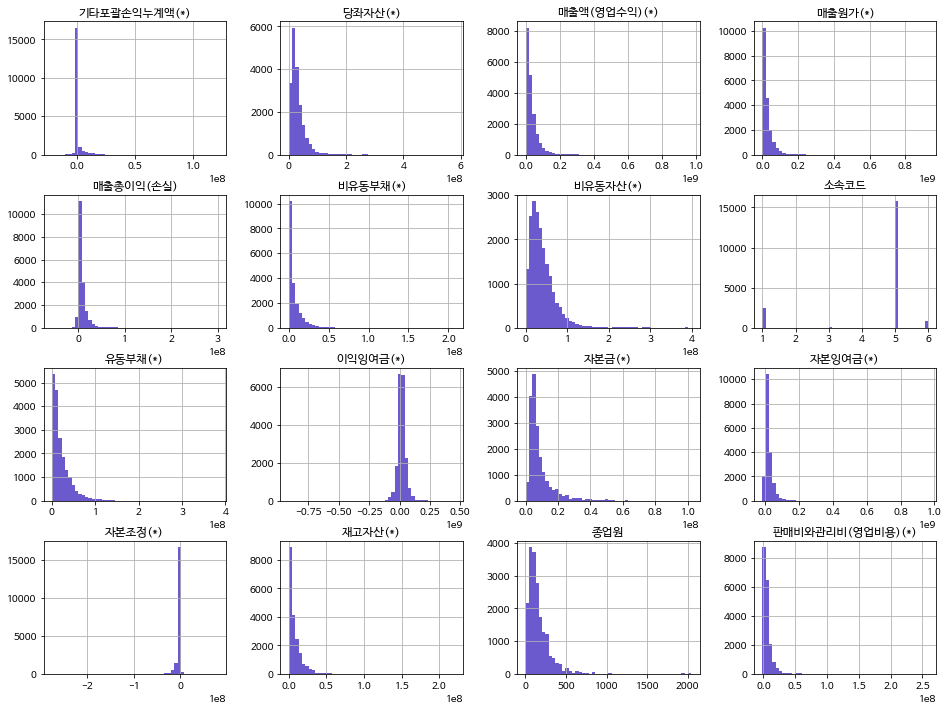

In [21]:
data.iloc[:,:20].hist(bins=50, figsize=(16,12), color='slateblue')
plt.show()

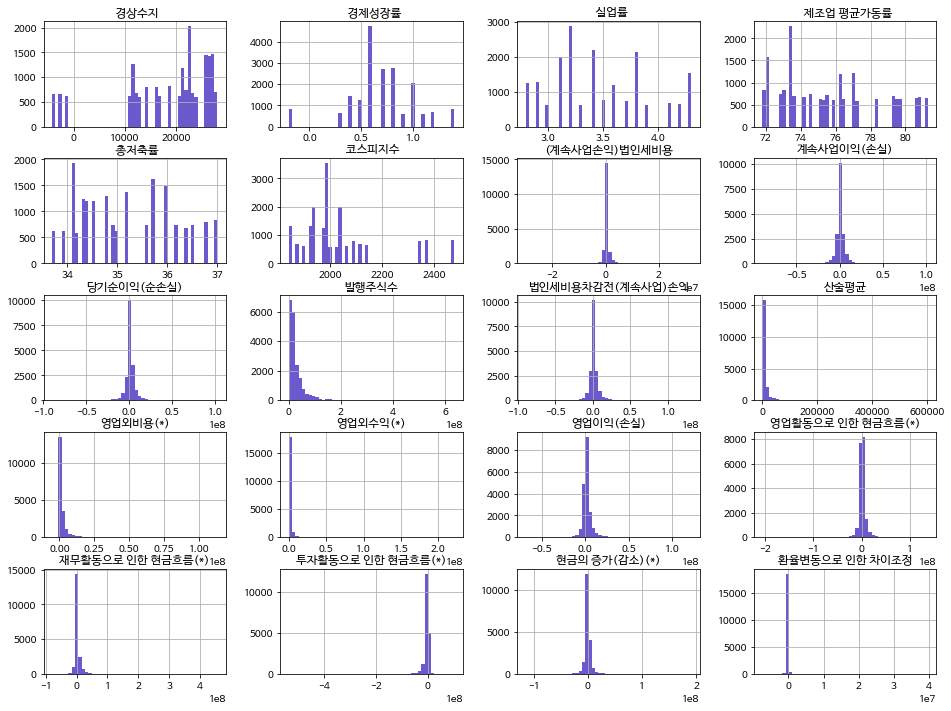

In [22]:
data.iloc[:,20:].hist(bins=50, figsize=(16,12),color='slateblue')
plt.show()

왼쪽에 데이터가 몰려있는 경우가 많으니 몇 특성들을 골라서 log변환을 해야한다.
- 특성들
    - 당좌자산(\*), 매출액(영업수익)(\*), 매출원가(\*), 매출총이익(손실), 비유동부채(\*), 비유동자산(\*)
    - 유동부채(\*) 자본금(\*) 자본잉여금(\*) 재고자산(\*) 종업원 판매비와관리비(영업비용)(\*)
    - 발행주식수 영업외비용(\*) 재무활동으로 인한 현금흐름(\*)

# 상관관계 조사

In [23]:
corr_matrix = data.corr()
print(corr_matrix["산술평균"].sort_values(ascending=False))
len(corr_matrix["산술평균"].sort_values(ascending=False))

산술평균                 1.000000
영업이익(손실)             0.322224
법인세비용차감전(계속사업)손익     0.282368
당좌자산(*)              0.275939
계속사업이익(손실)           0.263871
당기순이익(순손실)           0.261690
(계속사업손익)법인세비용        0.247331
매출총이익(손실)            0.235349
이익잉여금(*)             0.216637
영업활동으로 인한 현금흐름(*)    0.191378
자본잉여금(*)             0.180849
비유동자산(*)             0.169862
재무활동으로 인한 현금흐름(*)    0.146716
종업원                  0.138760
비유동부채(*)             0.113547
판매비와관리비(영업비용)(*)     0.104426
  총저축률               0.085870
매출액(영업수익)(*)         0.077415
  경상수지               0.061542
현금의 증가(감소)(*)        0.054659
 코스피지수               0.049543
영업외수익(*)             0.042651
  실업률                0.042145
기타포괄손익누계액(*)         0.025396
유동부채(*)              0.024945
재고자산(*)              0.015128
매출원가(*)              0.014056
  경제성장률             -0.006680
환율변동으로 인한 차이조정      -0.009145
영업외비용(*)            -0.010153
소속코드                -0.021242
  제조업 평균가동률         -0.092954
발행주식수               -0.113219
자본조정(*)   

36

상관 관계가 높은 특성들은 "산술평균", "영업이익(손실)", "당좌자산(\*)", "법인세비용차감전(계속사업)손익", "자본금(\*)", "산술평균", "당기순이익(순손실)", "계속사업이익(손실)", "매출총이익(손실)"이다.

이를 산점도로 그려보자

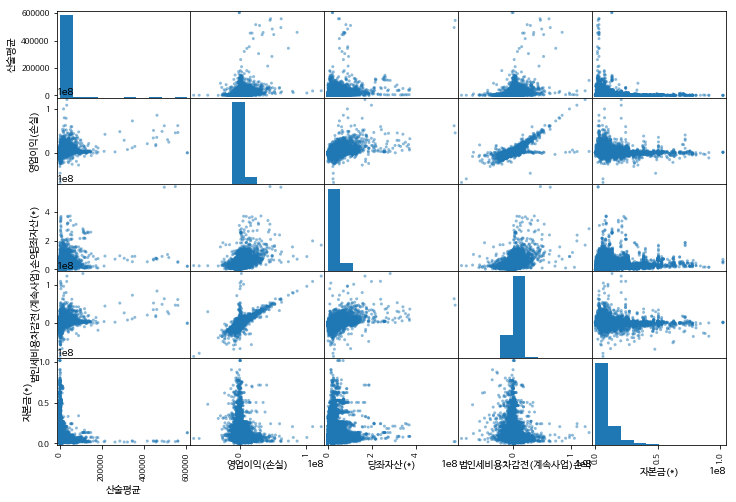

In [24]:
from pandas.plotting import scatter_matrix

attributes1 = ["산술평균","영업이익(손실)", "당좌자산(*)", "법인세비용차감전(계속사업)손익", "자본금(*)"]
scatter_matrix(data[attributes1], figsize=(12, 8))
plt.show()

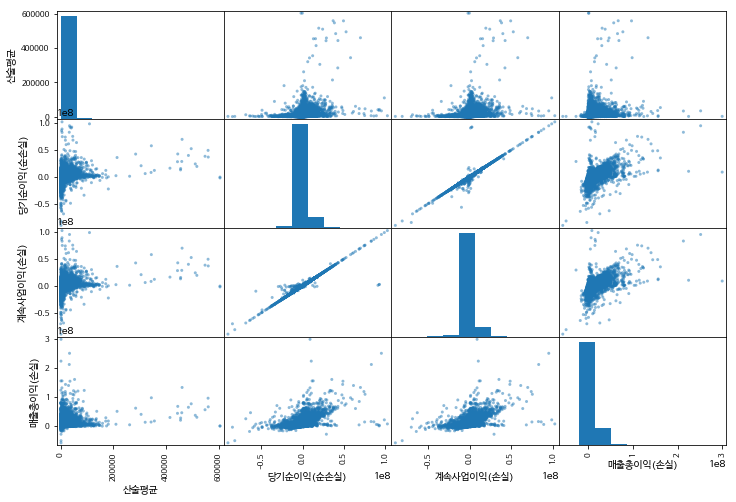

In [25]:
attributes2 = ["산술평균","당기순이익(순손실)", "계속사업이익(손실)", "매출총이익(손실)"]
scatter_matrix(data[attributes2], figsize=(12, 8))
plt.show()

상관 관계를 조사해본 결과, 각 특성들끼리 상관도가 굉장히 높다. 이런 경우를 해결하기 위해 PCA 전처리를 추가해야한다.

#### 수치형 데이터 log화와 PCA

log화가 필요한 데이터들
    - 당좌자산(\*), 매출액(영업수익)(\*), 매출원가(\*), 매출총이익(손실), 비유동부채(\*), 비유동자산(\*)
    - 유동부채(\*), 자본금(\*), 자본잉여금(\*), 재고자산(\*), 종업원 판매비와관리비(영업비용)(\*)
    - 발행주식수 영업외비용(\*), 재무활동으로 인한 현금흐름(\*)  
PCA를 할 데이터들
    - 당좌자산(\*)~현금의 증가(감소)(\*)
    -   경제성장률 ~ 경상수지

#### log화

In [26]:
log_data = ["당좌자산(*)", "매출액(영업수익)(*)", "매출원가(*)", "매출총이익(손실)", "비유동부채(*)", "비유동자산(*)", "유동부채(*)" ,
     "자본금(*)", "자본잉여금(*)", "재고자산(*)", "종업원", "판매비와관리비(영업비용)(*)",
    "발행주식수", "영업외비용(*)", "재무활동으로 인한 현금흐름(*)"  ]
data_log = data[log_data].copy()
for i in log_data:
    data_log.loc[:, i] = data_log[i] - data_log[i].min() + 1
data_log = np.log(data_log)

In [27]:
data_final = data.drop(log_data, axis=1).join(data_log).copy()

#### PCA

In [28]:
micro_att = ['당좌자산(*)','재고자산(*)','비유동자산(*)','유동부채(*)','비유동부채(*)',
        '자본금(*)','자본잉여금(*)','자본조정(*)','기타포괄손익누계액(*)',
        '이익잉여금(*)','매출액(영업수익)(*)','매출원가(*)','매출총이익(손실)',
        '판매비와관리비(영업비용)(*)','영업이익(손실)','영업외수익(*)','영업외비용(*)',
        '법인세비용차감전(계속사업)손익','(계속사업손익)법인세비용','계속사업이익(손실)',
        '당기순이익(순손실)','영업활동으로 인한 현금흐름(*)',
        '투자활동으로 인한 현금흐름(*)','재무활동으로 인한 현금흐름(*)',
       '환율변동으로 인한 차이조정','현금의 증가(감소)(*)']

macro_att = ['  경제성장률','  총저축률','  제조업 평균가동률','  실업률',
            ' 코스피지수','  경상수지']

PCA_micro = data_final[micro_att].copy()
PCA_macro = data_final[macro_att].copy()

먼저 주어진 데이터를 95%이상 설명가능한 차원의 수를 각각 구하자.

In [29]:
from sklearn.decomposition import PCA

pca1 = PCA()
pca1.fit(PCA_micro)
cumsum = np.cumsum(pca1.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
d1 = np.argmax(cumsum>=0.90)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

pca1 = PCA(n_components=d1)

pca1.fit_transform(PCA_micro), d1

(array([[ 6.11592031e+07,  4.30609863e+06, -7.98157039e+06],
        [ 6.04173628e+07,  6.12775806e+06, -6.51073752e+06],
        [ 6.02488101e+07,  6.61698913e+06, -5.70482397e+06],
        ...,
        [-4.06540697e+07,  3.95676805e+07, -3.05557891e+07],
        [-7.20699315e+07,  3.75534000e+08,  2.18675916e+08],
        [-9.36808142e+07,  4.61452756e+08,  2.77814756e+08]]), 3)

In [30]:
index_micro = PCA_micro.index
        
col = []
for i in range(d1):
    col.append('pca1_%s' %i)
        
XdD1 = pd.DataFrame(pca1.transform(PCA_micro), 
                    index=index_micro, columns = col)
XdD1.head()

,pca1_0,pca1_1,pca1_2
0,6.115920e+07,4.306099e+06,-7.981570e+06
1,6.041736e+07,6.127758e+06,-6.510738e+06
2,6.024881e+07,6.616989e+06,-5.704824e+06
3,6.273563e+07,4.084086e+06,-4.891368e+06
4,6.225285e+07,4.420132e+06,-8.054257e+06


In [31]:
pca2 = PCA()
pca2.fit(PCA_macro)
cumsum = np.cumsum(pca2.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
d2 = np.argmax(cumsum>=0.95)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

pca2 = PCA(n_components=d2)

pca2.fit_transform(PCA_macro), d2

(array([[22485.46636485],
        [20702.90982998],
        [ 6826.91705162],
        ...,
        [ 3777.15501433],
        [-7712.35330481],
        [ -618.7432483 ]]), 1)

In [32]:
index_macro = PCA_macro.index
        
col = []
for i in range(d2):
    col.append('pca2_%s' %i)
        
XdD2 = pd.DataFrame(pca2.transform(PCA_macro), 
                    index=index_macro, columns = col)
XdD2.head()

,pca2_0
0,22485.466365
1,20702.909830
2,6826.917052
3,6276.342030
4,19524.385238


#### 데이터 log화와 PCA

In [33]:
data_final = data.drop(log_data, axis=1).join(data_log).copy()

In [34]:
data_final.drop(PCA_micro, axis=1, inplace=True)
data_final.drop(PCA_macro, axis=1, inplace=True)

In [35]:
data_final = data_final.join(XdD1)
data_final = data_final.join(XdD2)

In [36]:
log = data_final["산술평균"] - data_final["산술평균"].min() + 0.01

In [37]:
log_labels = np.log(data_final["산술평균"].copy())
data_final["log_labels"] = log_labels

#### 시각화

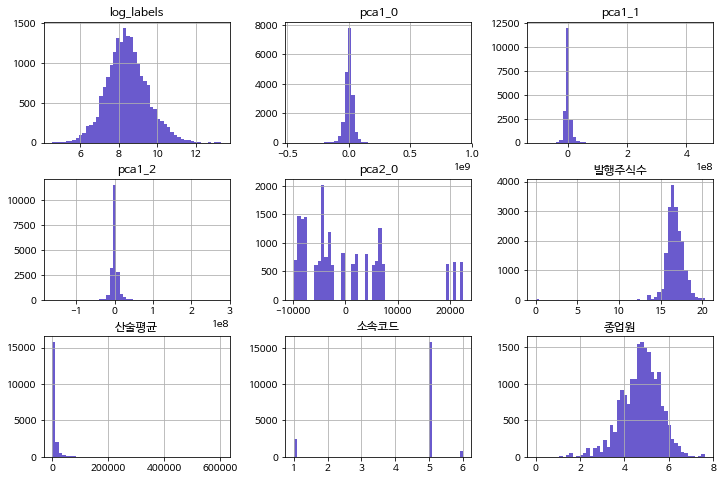

In [38]:
data_final.hist(bins=50, figsize=(12,8), color='slateblue')
plt.show()

In [39]:
corr_matrix = data_final.corr()
corr_matrix["log_labels"].sort_values(ascending=False)

log_labels    1.000000
산술평균          0.584109
종업원           0.274476
pca1_1        0.198529
소속코드          0.067300
pca1_2       -0.010453
pca2_0       -0.115199
pca1_0       -0.386227
발행주식수        -0.455139
Name: log_labels, dtype: float64

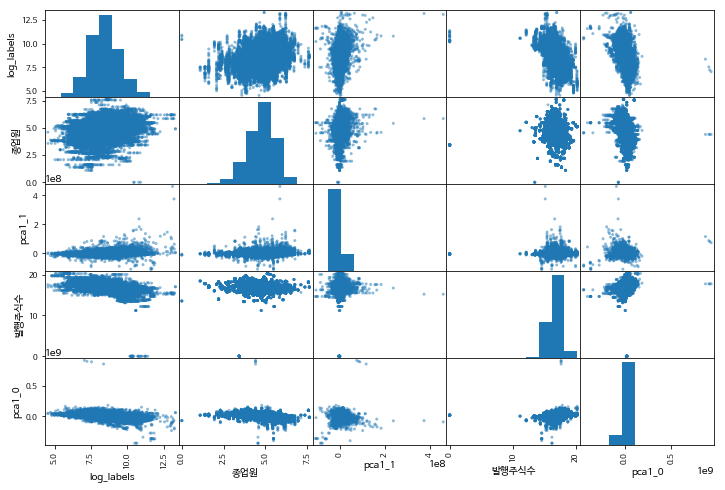

In [40]:
attributes = ["log_labels","종업원", "pca1_1", "발행주식수", "pca1_0"]
scatter_matrix(data_final[attributes], figsize=(12, 8))
plt.show()

#### 분기 추가

분기별 산술평균의 차이는 두드러지지 않지만, 1분기와 나머지 분기를 나눌 수 있을 것 같다.

In [41]:
data_final["분기"] = data_final["회계년도"].str.split("-", n=2, expand=True)[1]
data_quater = data_final[["분기", "산술평균"]]

,산술평균
분기,
03,8619.798210
06,9045.449936
09,8877.567015
12,8829.768635


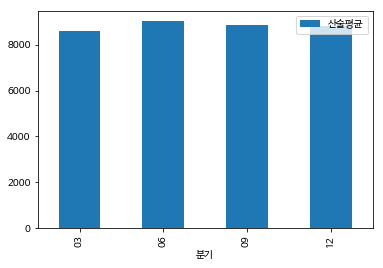

In [42]:
display(data_quater.groupby("분기").mean())
display(data_quater.groupby("분기").mean().plot.bar())

# 머신러닝 알고리즘에 학습시키기 위해 데이터를 전처리하자.

1. train set, test set 나누기
2. 특성값, 타겟값 log화
3. PCA
4. 설립일에서 연도만 추출하기
5. 회계년도에서 분기 추출하기(명목화)

In [43]:
data_final.head()

,회사명,회계년도,산업명,소속코드,설립일,기업규모명,산술평균,종업원,발행주식수,pca1_0,pca1_1,pca1_2,pca2_0,log_labels,분기
0,(주)CMG제약,2011-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,873.0,5.351858,18.502073,6.115920e+07,4.306099e+06,-7.981570e+06,22485.466365,6.771936,03
1,(주)CMG제약,2011-06-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,577.0,5.351858,18.502073,6.041736e+07,6.127758e+06,-6.510738e+06,20702.909830,6.357842,06
2,(주)CMG제약,2011-09-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,993.0,5.351858,18.502073,6.024881e+07,6.616989e+06,-5.704824e+06,6826.917052,6.900731,09
3,(주)CMG제약,2011-12-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,775.0,5.351858,18.502073,6.273563e+07,4.084086e+06,-4.891368e+06,6276.342030,6.652863,12
4,(주)CMG제약,2012-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,892.0,5.351858,18.502073,6.225285e+07,4.420132e+06,-8.054257e+06,19524.385238,6.793466,03


In [44]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19107 entries, 0 to 47773
Data columns (total 15 columns):
회사명           19107 non-null object
회계년도          19107 non-null object
산업명           19107 non-null object
소속코드          19107 non-null float64
설립일           19107 non-null object
기업규모명         19107 non-null object
산술평균          19107 non-null float64
종업원           19107 non-null float64
발행주식수         19107 non-null float64
pca1_0        19107 non-null float64
pca1_1        19107 non-null float64
pca1_2        19107 non-null float64
pca2_0        19107 non-null float64
log_labels    19107 non-null float64
분기            19107 non-null object
dtypes: float64(9), object(6)
memory usage: 3.0+ MB


## 1. train 데이터와 test 데이터 나누기

In [45]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data, test_size=0.2, random_state=42)

labels = train["산술평균"]
log_labels = np.log(labels)
train.drop(["산술평균"], axis=1, inplace=True)

c:\python\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## 2. 특성값 log화

train set, test set 나누기
특성값, 타겟값 log화
설립일에서 연도만 추출하기
회계년도에서 분기 추출하기(명목화)

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

In [47]:
class numeric_log(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_log = X[log_data].copy()
        for i in log_data:
            X_log.loc[:, i] = X_log[i] - X_log[i].min() + 1
        X_log = X_log - X_log.min().min() + 1
        X_log = np.log(X_log)
        tmp = X.drop(log_data, axis=1)
        
        
        return tmp.join(X_log)

## 3. PCA

In [48]:
class numeric_PCA(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        PCA_micro = X[micro_att].copy()
        PCA_macro = X[macro_att].copy()
        
        ## micro
        pca1 = PCA()
        pca1.fit(PCA_micro)
        cumsum = np.cumsum(pca1.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
        d1 = np.argmax(cumsum>=0.90)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

        pca1 = PCA(n_components=d1)
        pca1.fit(PCA_micro)
        
        ## macro
        pca2 = PCA()
        pca2.fit(PCA_macro)
        cumsum = np.cumsum(pca2.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
        d2 = np.argmax(cumsum>=0.95)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

        pca2 = PCA(n_components=d2)
        pca1.fit(PCA_macro)
        
        return self
    
    def transform(self, X, y=None):
        ## micro
        self.PCA_micro = X[micro_att].copy()
        self.PCA_macro = X[macro_att].copy()
        
        self.index_micro = self.PCA_micro.index
        self.col = []
        for i in range(d1):
            self.col.append('pca1_%s' %i)
        
        XdD1 = pd.DataFrame(pca1.transform(self.PCA_micro), 
                                index=self.index_micro, columns = self.col)
        
        ## macro
        self.index_macro = self.PCA_macro.index
        
        self.col = []
        for i in range(d2):
            self.col.append('pca2_%s' %i)
        
        XdD2 = pd.DataFrame(pca2.transform(self.PCA_macro), 
                            index=self.index_macro, columns = self.col)
        
        X.drop(self.PCA_micro, axis=1, inplace=True)
        X.drop(self.PCA_macro, axis=1, inplace=True)        
    
        
        X = X.join(XdD1)
        X = X.join(XdD2)
        
        return X

## 4. 설립일에서 연도만 추출하기

In [49]:
class cat_date_of_establish(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["설립일"] = X["설립일"].str.split('-', n = 1, expand=True)[0].astype("float")
        return X

## 5. 회계년도 분기 추출

In [50]:
class cat_add_quater(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["분기"] = X["회계년도"].str.split("-", n=2, expand=True)[1]
        X.drop(["회계년도"], axis=1, inplace=True)
        return X

## 6. 회사명, 기업규모명, 소속코드 지우기

In [51]:
class cat_drop_some_attributes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(["회사명", "기업규모명", "소속코드"], axis=1)

## 파이프라인 구축

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_attributes = ["회사명", "기업규모명", "소속코드", "산업명", '회계년도']
num_attributes = []
for i in train.columns:
    if i not in cat_attributes:
        num_attributes.append(i)

In [53]:
num_pipeline = Pipeline([
        ('log',numeric_log()),
        ('PCA',numeric_PCA()),
        ('data_of_establish', cat_date_of_establish()),
        ('StandardScaler',StandardScaler()),
    ])

In [54]:
cat_pipeline = Pipeline([

        ('add_quater', cat_add_quater()),
        ('drop_some_attributes',cat_drop_some_attributes()),
        ('onehotencoder',OneHotEncoder(categories='auto')),
    ])

In [55]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes),
        ("cat", cat_pipeline, cat_attributes),
    ])

In [56]:
train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(15285, 62)

## 머신러닝 트레이닝

In [57]:
from sklearn.metrics import mean_squared_error

### LinearRegression

In [58]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, log_labels)

train_predictions = lin_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
lin_mse = mean_squared_error(labels, real_train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

334178.27089912107

### DecisionTreeRegressor

In [59]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=40)
tree_reg.fit(train_prepared, log_labels)

train_predictions = tree_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
tree_mse = mean_squared_error(labels, real_train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.5061614094993291

### SVM regression

In [60]:
from sklearn.svm import SVR
svm_reg = SVR(degree=10, gamma='auto', C=10, epsilon=2)
svm_reg.fit(train_prepared, log_labels)

train_predictions = svm_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
svm_mse = mean_squared_error(labels, real_train_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

17133.037116432664

### RandomForestRegressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=55, random_state=42, max_depth=40)
forest_reg.fit(train_prepared, log_labels)

train_predictions = forest_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
forest_mse = mean_squared_error(labels, real_train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

6494.5617949397865

## cross val score 
여기서 score은 log들끼리 뺀 것

모델 선정

In [62]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

### Linear regression

In [63]:
scores = cross_val_score(lin_reg, train_prepared, log_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [0.7685911  0.80496396 0.77913806 0.82374187 0.79688136 0.73448602
 0.7771858  0.76344426 0.78396974 0.77318277]
Mean: 0.7805584923264787
Standard deviation: 0.02316265369132502


### DecisionTreeRegressor

In [64]:
scores = cross_val_score(tree_reg, train_prepared, log_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [0.63491811 0.64028985 0.63461485 0.58548338 0.6375239  0.59637056
 0.62635598 0.63785128 0.59443101 0.63190736]
Mean: 0.6219746277691593
Standard deviation: 0.02005065962282126


### SVR

In [65]:
scores = cross_val_score(svm_reg, train_prepared, log_labels,
scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)
display_scores(svm_rmse_scores)

Scores: [0.83823185 0.86282967 0.85045842 0.85843455 0.86423468 0.82225781
 0.84406874 0.83280316 0.84628457 0.85345369]
Mean: 0.8473057138270036
Standard deviation: 0.012770078098374934


### RandomForestRegressor

In [69]:
scores = cross_val_score(forest_reg, train_prepared, log_labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [0.43130958 0.46309477 0.44839149 0.43352916 0.43963182 0.41984287
 0.42975992 0.45103107 0.4370169  0.45783129]
Mean: 0.44114388618956524
Standard deviation: 0.012914871232002042


### 랜덤 그리드 탐색

#### SVR

In [68]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'C':(1,0.25,0.5,0.75,3,4,5,6,7,8,9,10), 'gamma': (1,2,3,'auto')}

n_iter_search = 20
random_search = RandomizedSearchCV(svm_reg, param_distributions=parameters,
                                   n_iter=n_iter_search, cv=5, random_state=0)
random_search.fit(train_prepared, log_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=10, epsilon=2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'C': (1, 0.25, 0.5, 0.75, 3, 4, 5, 6, 7, 8, 9, 10), 'gamma': (1, 2, 3, 'auto')},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [70]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.13959964765364785 {'gamma': 2, 'C': 6}
0.25016510658641794 {'gamma': 1, 'C': 0.25}
0.07407252826886465 {'gamma': 3, 'C': 5}
0.07407252826886465 {'gamma': 3, 'C': 6}
0.30262199448254323 {'gamma': 1, 'C': 7}
0.13959964765364785 {'gamma': 2, 'C': 8}
0.07407252826886465 {'gamma': 3, 'C': 7}
0.30262199448254323 {'gamma': 1, 'C': 9}
0.6005996315621186 {'gamma': 'auto', 'C': 0.25}
0.08259012556690995 {'gamma': 3, 'C': 0.5}
0.6035610544353074 {'gamma': 'auto', 'C': 0.5}
0.6054797791380294 {'gamma': 'auto', 'C': 6}
0.13959964765364785 {'gamma': 2, 'C': 7}
0.6061074215035647 {'gamma': 'auto', 'C': 5}
0.6029912865769471 {'gamma': 'auto', 'C': 10}
0.09366871827463899 {'gamma': 3, 'C': 1}
0.07407252826886465 {'gamma': 3, 'C': 10}
0.07407252826886465 {'gamma': 3, 'C': 3}
0.6060293826993962 {'gamma': 'auto', 'C': 0.75}
0.30262199448254323 {'gamma': 1, 'C': 6}


In [71]:
random_search.best_estimator_

SVR(C=5, cache_size=200, coef0=0.0, degree=10, epsilon=2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### RandomForest

In [72]:
from scipy.stats import randint as sp_randint

param_dist = {'n_estimators': [55],
                "max_depth": [40],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["mse"]}

n_iter_search = 20
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, random_state=0)
random_search.fit(train_prepared, log_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': [55], 'max_depth': [40], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA14268E80>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA14268128>, 'bootstrap': [True, False], 'criterion': ['mse']},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [73]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.8575359677230835 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 40, 'max_features': 6, 'min_samples_split': 2, 'n_estimators': 55}
0.845303008816548 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 40, 'max_features': 4, 'min_samples_split': 9, 'n_estimators': 55}
0.8500175850300461 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 40, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 55}
0.8337870064736315 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 40, 'max_features': 5, 'min_samples_split': 9, 'n_estimators': 55}
0.859064039902136 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 40, 'max_features': 9, 'min_samples_split': 10, 'n_estimators': 55}
0.799190903970703 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 40, 'max_features': 2, 'min_samples_split': 8, 'n_estimators': 55}
0.8759331828819805 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 40, 'max_features': 8, 'min_samples_split': 10, 'n_estimators': 55}
0.8624808761313284 {'boot

In [74]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=40,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=55, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

### SVR 마지막

In [75]:
from sklearn.svm import SVR
svm_reg = SVR(C=5, cache_size=200, coef0=0.0, degree=10, epsilon=2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svm_reg.fit(train_prepared, log_labels)

train_predictions = svm_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
svm_mse = mean_squared_error(labels, real_train_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

17190.29980258444

### 랜덤 포레스트 마지막 

In [76]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=40,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=55, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
forest_reg.fit(train_prepared, log_labels)

train_predictions = forest_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
forest_mse = mean_squared_error(labels, real_train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

6906.4710273216115

# 테스트

In [77]:
test_labels = test["산술평균"]
log_test_labels = np.log(test_labels)
test.drop(["산술평균"], axis=1, inplace=True)

c:\python\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [78]:
test_prepared = full_pipeline.transform(test)
test_prepared.shape

(3822, 62)

#### random forest

In [79]:
test_predictions = forest_reg.predict(test_prepared)
real_test_predictions = np.exp(test_predictions)
forest_mse = mean_squared_error(test_labels, real_test_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

13456.247146175096

기본모형 -> 13691  
15만원 -> 6626  
10만원 -> 6107    
9만원 -> 5734  
7만5천 -> 5260  
5만 -> 5003  
4만 -> 4138  
3만 -> 3305  

전체 데이터 -> 38908

#### SVR

In [87]:
svm_predictions = svm_reg.predict(test_prepared)
real_test_predictions = np.exp(svm_predictions)
svm_mse = mean_squared_error(test_labels, real_test_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

18427.395969302965

# 제출

In [81]:
submission = pd.read_csv('datasets//DB//submission.csv', engine='python')
submission["소속코드"] = 1
submission["기업규모명"] = '중소기업'
submission = submission[data.columns]

deadline = 30000

submission = submission[submission["산술평균"] < deadline]

In [82]:
submission_labels = submission["산술평균"]
log_submission_labels = np.log(submission_labels)
submission.drop(["산술평균"], axis=1, inplace=True)

In [83]:
submission_prepared = full_pipeline.transform(submission)
submission_prepared.shape

(16, 62)

#### Random forest

In [84]:
submission_predictions = forest_reg.predict(submission_prepared)
real_submission_predictions = np.exp(submission_predictions)
forest_mse = mean_squared_error(submission_labels, real_submission_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

6346.0421700197985

In [85]:
real_submission_predictions

array([19786.42308558,  9463.92578253,  9332.89239042, 18216.63363638,
        8213.06224752, 13175.24846529,  3760.65215887, 13727.59257922,
       32782.04510784, 18094.28883201, 17948.99232775, 28979.36897974,
       19981.749852  , 11318.24479275,  9554.11179654, 16210.15396163])

#### SVM

In [86]:
submission_predictions = svm_reg.predict(submission_prepared)
real_submission_predictions = np.exp(submission_predictions)
svm_mse = mean_squared_error(submission_labels, real_submission_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

7955.679769995431